In [1]:
import os
import warnings
os.chdir('../..')
warnings.filterwarnings('ignore')

# Data Loading

In [2]:
# Firstly import the class of dataset
from Scripts.Data_Loader import EIRDataset

EIR_Dataset = EIRDataset('./Generated/Data_Train/', task_type='all', n_jobs=72) # task type can be `geometric` or `random` or `all`

Loading .fif files: 100%|██████████| 651/651 [00:29<00:00, 22.16it/s]


In [3]:
import mne

# Это потомучто финальные 
min_len = 3946 

def resample_df(EIR_Dataset, freq: int):
    for i in range(len(EIR_Dataset)): 
        eeg_sample, eye_sample, metadata, label, img = EIR_Dataset[i]

        eeg_sample.resample(freq)

        # Обрезаем только нужное количество сэмплов
        data = eeg_sample.get_data()[:, :min_len]
        new_raw = mne.io.RawArray(data, eeg_sample.info, verbose=False)

        # Сохраняем обратно изменённый элемент
        EIR_Dataset[i] = (new_raw, eye_sample, metadata, label, img)

resample_df(EIR_Dataset, 256)

# Form X and y

In [4]:
from Scripts import Selectors_From_Dataset as sel
import numpy as np
X, img, y = sel.get_sample(EIR_Dataset)

# Here random patterns are set to 1
y = np.where(y == -1, 1, 0)

# Here geometric patterns are set to 1
# y = np.where(y != -1, 1, 0)

In [5]:
X.shape, y.shape

((651, 63, 3946), (651,))

# Model Train

In [6]:
import numpy as np
import scipy
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from pyriemann.estimation import XdawnCovariances
from pyriemann.tangentspace import TangentSpace
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn import metrics
import matplotlib.pyplot as plt
from pyriemann.estimation import Covariances
from typing import Union

n_components = 4
class ModelCovariance:
    class ParallelCovariances(BaseEstimator, TransformerMixin):
        def __init__(self, n_filters, covariance_type: Union[list, type] = Covariances):
            self.covariance_type = covariance_type
            self.n_filters = n_filters
            self.cov = []
            self.cov_pipeline = []

            for i, cov_type in enumerate(covariance_type):
                if cov_type == XdawnCovariances:
                    self.cov.append(cov_type(nfilter = self.n_filters[i], estimator = 'lwf', xdawn_estimator='lwf'))
                else: self.cov.append(cov_type(estimator = 'lwf'))
        def fit(self, X, y):
            self.cov_pipeline = []
            for i in range(len(X)):
                self.cov_pipeline.append(Pipeline([
                ('covariance', self.cov[i]),
                ('tangent', TangentSpace())]))
                self.cov_pipeline[i].fit(X[i], y)
            return self
        
        def transform(self, X):
            ret = []
            for i in range(len(X)):
                ret.append(self.cov_pipeline[i].transform(X[i]))
            combined = np.concatenate(ret, axis=1)
            return combined

        
    def __init__(self, feature_groups: int = 3, n_filters: Union[list, int, None] = 4, covariances: Union[list, type] = XdawnCovariances,
                  Classifier: Union[list, BaseEstimator] = LogisticRegression(C=3, class_weight='balanced', max_iter = 300)):
        self.feature_groups = feature_groups
        self.covariances = covariances
        self.n_filters = n_filters
        if feature_groups == 1: # Предполагается что в этом случае нигде не используется list для передачи параметров
            cov = covariances(estimator='lwf')
            if covariances == XdawnCovariances:
                cov = covariances(n_filters, estimator='lwf', xdawn_estimator='lwf')
            self.pipeline = Pipeline([
                ('cov', cov),
                ('tang', TangentSpace()),
                ('clf', Classifier)])
        else: # Если используем листы для передачи параметров - следим чтобы длина совпадала с feature_groups
            if isinstance(n_filters, int):
                self.n_filters = [n_filters] * feature_groups
            if isinstance(covariances, type):
                self.covariances = [covariances] * feature_groups
            self.pipeline = (Pipeline([
                ('cov', self.ParallelCovariances(self.n_filters, self.covariances)),
                ('clf', Classifier)]))
    def get_pipeline(self):
        return self.pipeline
    def fit(self, X, y):
        self.pipeline.fit(X, y)
        return self

    def predict(self, X):
        return self.pipeline.predict(X)
    
    def evaluate(self, X, true_y, metric: Union[str, list] = 'accuracy'):
        preds = self.pipeline.predict(X)
        if isinstance(metric, str):
            if metric == 'accuracy':
                return metrics.accuracy_score(true_y, preds)
            elif metric == 'precision':
                return metrics.precision_score(true_y, preds, average='weighted')
            elif metric == 'recall':
                return metrics.recall_score(true_y, preds, average='weighted')
            elif metric == 'f1':
                return metrics.f1_score(true_y, preds, average='weighted')
            elif metric == 'roc_auc':
                return metrics.roc_auc_score(true_y, preds)
            else:
                raise ValueError(f"Unknown metric: {metric}")
        
        elif isinstance(metric, list):
            results = {}
            for m in metric:
                if m == 'accuracy':
                    results[m] = metrics.accuracy_score(true_y, preds)
                elif m == 'precision':
                    results[m] = metrics.precision_score(true_y, preds, average='weighted')
                elif m == 'recall':
                    results[m] = metrics.recall_score(true_y, preds, average='weighted')
                elif m == 'f1':
                    results[m] = metrics.f1_score(true_y, preds, average='weighted')
                elif m == 'roc_auc':
                    results[m] = metrics.roc_auc_score(true_y, preds)
                else:
                    raise ValueError(f"Unknown metric: {m}")
            return results

In [7]:
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split


test_example = ModelCovariance(feature_groups=1, n_filters=80,
                               covariances=XdawnCovariances, 
                               Classifier=LogisticRegression(C=1, class_weight='balanced', max_iter = 1000))

# test_example2 = ModelCovariance(feature_groups=3, n_filters=4, 
#                                 covariances=[XdawnCovariances, Covariances, Covariances], 
#                                 Classifier=LogisticRegression(C=3, class_weight='balanced', max_iter = 300))

# test_example3 = ModelCovariance(feature_groups=2, n_filters=4, 
#                                 covariances=[XdawnCovariances, Covariances], 
#                                 Classifier=LogisticRegression(C=3, class_weight='balanced', max_iter = 300))

# test_example4 = ModelCovariance(feature_groups=2, n_filters=4, 
#                                 covariances=[XdawnCovariances, Covariances], 
#                                 Classifier=LogisticRegression(C=3, class_weight='balanced', max_iter = 300))

# test_example5 = ModelCovariance(feature_groups=2, n_filters=4, 
#                                 covariances=[Covariances, Covariances], 
#                                 Classifier=LogisticRegression(C=3, class_weight='balanced', max_iter = 300))

test_sizes = [0.10, 0.15, 0.20, 0.25, 0.30, 0.35, 0.40, 0.45, 0.50, 0.55]

for test_size in test_sizes:
    
    # X, img, y = sel.get_sample(EIR_Dataset)
    # subjects_cluster3 = [7, 7, 9, 9, 14]
    # trial_cluster3 = [2, 1, 2, 1, 1]
    # subjects_cluster4 = [5, 5, 3, 3, 2, 2, 10, 10, 12, 12, 16, 16, 11, 11, 13, 13]
    # trial_cluster4 = [2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1]
    # X, img, y = sel.get_sample_choosen_trial(EIR_Dataset, subjects_cluster4 + subjects_cluster3, trial_cluster4 + trial_cluster3)
    


    
    X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=test_size, stratify=y, random_state=42)

    # Smote только на тренировочном сете
    smote = SMOTE(random_state=42)
    _, n_channels, n_timepoints = X_train.shape
    X_flat = X_train.reshape(X_train.shape[0], -1)
    X_resampled_flat, Y_train = smote.fit_resample(X_flat, Y_train)
    X_train = X_resampled_flat.reshape(-1, n_channels, n_timepoints) 
    
    test_example.fit(X_train, Y_train)
    print(f"---------- For Test_Size {test_size} ------ Random Guess: {Y_test.sum()/len(Y_test):.3f} ----------")
    print(test_example.evaluate(X_test, Y_test, ['accuracy', 'precision', 'recall', 'f1']))

# test_example2.fit([X_train, power_wav_train, phase_wav_train], Y_train)
# print(test_example2.evaluate([X_test, power_wav_test, phase_wav_test], Y_test, ['accuracy', 'f1']))

# test_example3.fit([X_train, power_wav_train], Y_train)
# print(test_example3.evaluate([X_test, power_wav_test], Y_test, ['accuracy', 'f1']))

# test_example4.fit([X_train, phase_wav_train], Y_train)
# print(test_example4.evaluate([X_test, phase_wav_test], Y_test, ['accuracy', 'f1']))

# test_example5.fit([power_wav_train, phase_wav_train], Y_train)
# print(test_example5.evaluate([power_wav_test, phase_wav_test], Y_test, ['accuracy', 'f1']))

---------- For Test_Size 0.1 ------ Random Guess: 0.333 ----------
{'accuracy': 0.803030303030303, 'precision': 0.8242424242424242, 'recall': 0.803030303030303, 'f1': 0.7811447811447811}
---------- For Test_Size 0.15 ------ Random Guess: 0.337 ----------
{'accuracy': 0.7653061224489796, 'precision': 0.7627551020408163, 'recall': 0.7653061224489796, 'f1': 0.7471908145762594}
---------- For Test_Size 0.2 ------ Random Guess: 0.336 ----------
{'accuracy': 0.7633587786259542, 'precision': 0.7627567334005474, 'recall': 0.7633587786259542, 'f1': 0.7424258839215443}
---------- For Test_Size 0.25 ------ Random Guess: 0.331 ----------
{'accuracy': 0.7668711656441718, 'precision': 0.7619754992880303, 'recall': 0.7668711656441718, 'f1': 0.7501745818238059}
---------- For Test_Size 0.3 ------ Random Guess: 0.332 ----------
{'accuracy': 0.7806122448979592, 'precision': 0.777818270165209, 'recall': 0.7806122448979592, 'f1': 0.7658856754703848}
---------- For Test_Size 0.35 ------ Random Guess: 0.333

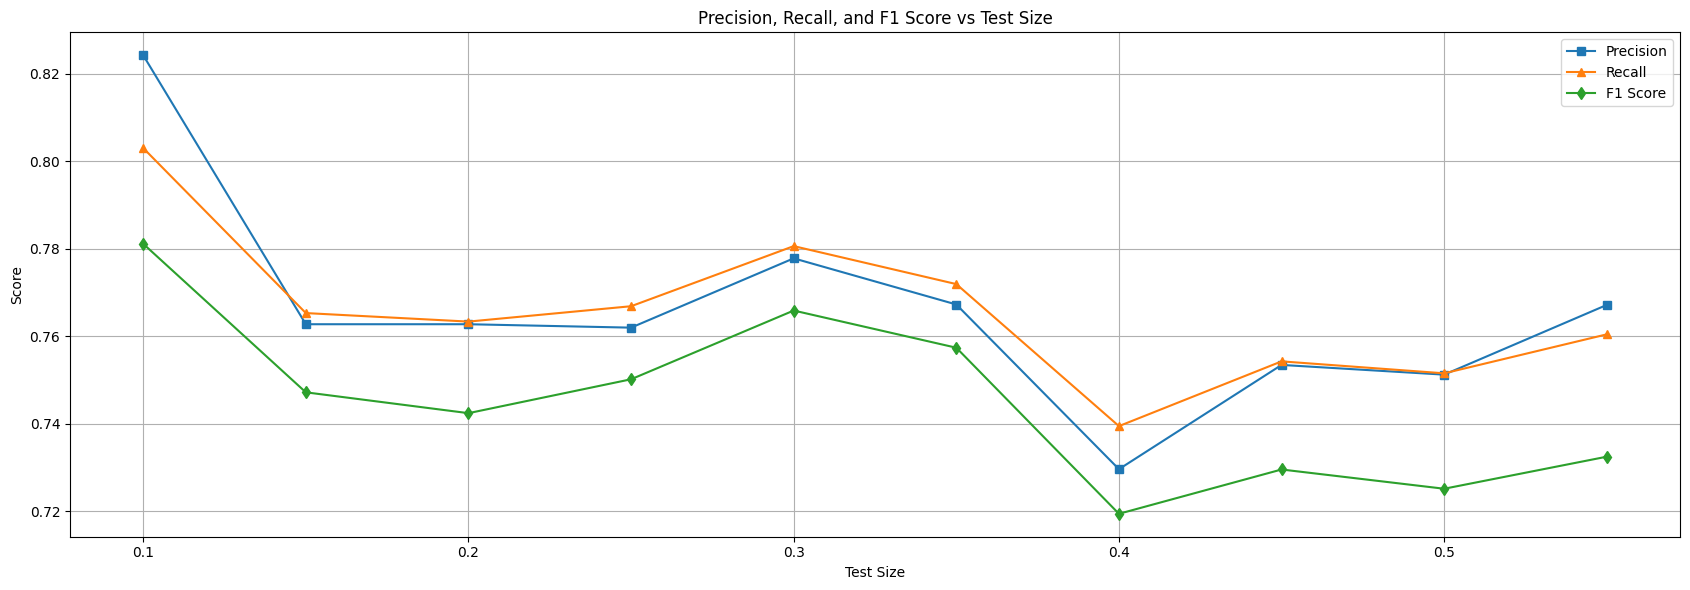

In [14]:
import matplotlib.pyplot as plt

# Test sizes
test_sizes = [0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55]

# Metrics (excluding Accuracy)
precisions = [
    0.8242424242424242,
    0.7627551020408163,
    0.7627567334005474,
    0.7619754992880303,
    0.777818270165209,
    0.7672659176029962,
    0.7296202225447508,
    0.7534519139535213,
    0.7512326743921837,
    0.7671725312257576
]

recalls = [
    0.803030303030303,
    0.7653061224489796,
    0.7633587786259542,
    0.7668711656441718,
    0.7806122448979592,
    0.7719298245614035,
    0.7394636015325671,
    0.7542662116040956,
    0.7515337423312883,
    0.7604456824512534
]

f1_scores = [
    0.7811447811447811,
    0.7471908145762594,
    0.7424258839215443,
    0.7501745818238059,
    0.7658856754703848,
    0.7573833573833573,
    0.719421590625779,
    0.7295500516642139,
    0.7251487933338753,
    0.7324777407998591
]

# Plotting
plt.figure(figsize=(17, 6))  # narrower width
plt.plot(test_sizes, precisions, marker='s', label='Precision')
plt.plot(test_sizes, recalls, marker='^', label='Recall')
plt.plot(test_sizes, f1_scores, marker='d', label='F1 Score')

plt.xlabel('Test Size')
plt.ylabel('Score')
plt.title('Precision, Recall, and F1 Score vs Test Size')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()